### Preprocess MOSTA data

The Stereo-seq data were provided in bin-50 resolution, we reprocessed the spot coordinates to align them with pixel-based image coordinates, using the Bin1 matrix files available on the dataset website (E16.5_E2S6_GEM_bin1.tsv.gz, E16.5_E2S7_GEM_bin1.tsv.gz)

Steps:
- Map pixel coordinates to count matrix coordinates
- Compute intersection and sort variable names to match between sections
- Make index names unique and add .obs['section']

**Download**: https://db.cngb.org/stomics/mosta/download/

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import cosine
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

valid_data = '/exports/archive/hg-funcgenom-research/bmanzato_valid_data/MOSTA_Mouse_Embryo_Stereoseq/'

In [ ]:
# read count data (cm = count matrix)

# E2S6
e2s6_cm = ad.read_h5ad(f'{valid_data}data/E16.5_E2S6.MOSTA.h5ad')
# E2S7
e2s7_cm = ad.read_h5ad(f'{valid_data}data/E16.5_E2S7.MOSTA.h5ad')

print('Number of E2S6 spots: '+str(e2s6_cm.shape[0]))
print('Number of E2S7 spots: '+str(e2s7_cm.shape[0]))

In [ ]:
e2s6_cm.X

The E16.5_E2S6.MOSTA.h5ad file is a binned matrix, it contains 50 x 50 aggregated DNBs (bin 50 matrix). The matrix that match with the image is this bin 1 matrix E16.5_E2S6_GEM_bin1.tsv.gz.
 
The ‘spatial’ coordinates presented in the ‘obsm’ slot of h5ad object is not the actual coordinates. That is the rotated one for better presentation. The actual transformed coordinates is stored in the bin name (adata.obs.index , in X_Y format).
 
The actual transformed coordinates were obtained with the following code from bin 1 matrix:

In [3]:
binsize = 50

In [4]:
# E2S6
e2s6_bin = pd.read_csv(f"{valid_data}data/E16.5_E2S6_GEM_bin1.tsv", sep = "\t")

# 1. Transform to integer
x, y = e2s6_bin['x'].astype("int32"), e2s6_bin['y'].astype("int32")

# 2. Divide bin coordinates by binsize (50)
e2s6_bin['y_rou'] = np.round(x/binsize).astype('int32')
e2s6_bin['x_rou'] = np.round(y/binsize).astype('int32')

# 3. Extract the x and y values from the 'spatial' array and add them to 'obs'and round them
e2s6_cm.obs['x_rou'] = -e2s6_cm.obsm['spatial'][:, 0]
e2s6_cm.obs['y_rou'] = e2s6_cm.obsm['spatial'][:, 1]

# 4. Creat column xy_rou
e2s6_cm.obs['xy_rou'] = e2s6_cm.obs['x_rou'].astype(int).astype(str) + '_' + e2s6_cm.obs['y_rou'].astype(int).astype(str)

# 5. Make xy pairs unique in e2s6_bin unique (to reduce big size)
e2s6_bin_unique = e2s6_bin.drop_duplicates(subset=['x_rou', 'y_rou'])
e2s6_bin_unique = e2s6_bin_unique.rename(columns={'x': 'x_bin', 'y': 'y_bin'})

# 6. Add xy_rou to e2s6_bin_unique so that it can be later used for matching
e2s6_bin_unique['xy_rou'] = e2s6_bin_unique['x_rou'].astype(str) + '_' + e2s6_bin_unique['y_rou'].astype(str)
e2s6_bin_unique['xy_bin'] = e2s6_bin_unique['x_bin'].astype(str) + '_' + e2s6_bin_unique['y_bin'].astype(str)

# 7. Create dict
xy_bin_to_xy_rou = e2s6_bin_unique.set_index('xy_rou')['xy_bin'].to_dict()
for key, value in list(xy_bin_to_xy_rou.items())[:5]:
    print(f'{key}: {value}')
# keys: barcodes shared by bin file and AnnData obs
# values: bin-coord 

198_314: 15718_9915
78_234: 11682_3904
254_274: 13705_12695
295_502: 25122_14764
111_435: 21747_5528


In [5]:
# 8. MAP bin coordinates to 
e2s6_cm.obs['xy_pixel'] = e2s6_cm.obs['xy_rou'].map(xy_bin_to_xy_rou)
# remove nas rows
e2s6_cm = e2s6_cm[e2s6_cm.obs['xy_pixel'].notna()]
# split and turn into numeric
e2s6_cm.obs[['y_pxl', 'x_pxl']] = e2s6_cm.obs['xy_pixel'].str.split('_', expand=True).astype(int)

In [6]:
e2s6_cm.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,annotation,Regulon - 2310011J03Rik,Regulon - Alx1,Regulon - Alx3,Regulon - Alx4,Regulon - Ar,...,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,x_rou,y_rou,xy_rou,xy_pixel,y_pxl,x_pxl
cell_name,,,,,,,,,,,,,,,,,,,,,
100_103,721,6.582025,1532,7.334982,Epidermis,0.000000,0.036446,0.015920,0.105312,0.002124,...,39.621410,50.522193,64.164491,85.574413,103.0,100.0,103_100,5023_5149,5023,5149
100_104,1428,7.264730,3328,8.110427,Epidermis,0.228960,0.042422,0.010293,0.072175,0.057089,...,32.271635,41.676683,52.824519,72.115385,104.0,100.0,104_100,5025_5200,5025,5200
100_105,1520,7.327123,3930,8.276649,Epidermis,0.222322,0.096303,0.108122,0.095805,0.000000,...,33.460560,42.519084,53.511450,71.628499,105.0,100.0,105_100,4995_5253,4995,5253
100_106,1312,7.180070,3379,8.125631,Connective tissue,0.327966,0.074261,0.012105,0.139118,0.060429,...,38.887245,47.232909,57.561409,75.969222,106.0,100.0,106_100,5014_5294,5014,5294
100_107,865,6.763885,1805,7.498870,Connective tissue,0.196967,0.094585,0.003302,0.193237,0.001445,...,36.842105,46.426593,58.947368,79.778393,107.0,100.0,107_100,4984_5326,4984,5326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_299,754,6.626718,1625,7.393878,Cavity,0.209245,0.135860,0.082692,0.167482,0.091911,...,44.492308,53.230769,65.538462,84.369231,299.0,99.0,299_99,4927_14931,4927,14931
99_300,807,6.694562,1915,7.557995,Cavity,0.113442,0.037216,0.054211,0.073894,0.116577,...,46.161880,55.248042,66.370757,83.968668,300.0,99.0,300_99,4939_15010,4939,15010
99_301,1006,6.914731,2130,7.664347,Epidermis,0.270231,0.068877,0.081891,0.069411,0.000833,...,35.117371,44.553991,56.431925,76.244131,301.0,99.0,301_99,4947_15056,4947,15056


In [40]:
# reverse the values
e2s6_cm.obs['x_pxl'] = e2s6_cm.obs['x_pxl'].max() - e2s6_cm.obs['x_pxl']
e2s6_cm.obs['y_pxl'] = e2s6_cm.obs['y_pxl'].max() - e2s6_cm.obs['y_pxl']

e2s6_cm.obs['y_pxl'] = e2s6_cm.obs['y_pxl'].max() - e2s6_cm.obs['y_pxl']
e2s6_cm.obs['x_pxl'] = e2s6_cm.obs['x_pxl'].max() - e2s6_cm.obs['x_pxl']

In [ ]:
e2s6_cm.obs

In [41]:
# E2S7
e2s7_bin = pd.read_csv(f"{valid_data}data/E16.5_E2S7_GEM_bin1.tsv", sep = "\t")
x, y = e2s7_bin['x'].astype("int32"), e2s7_bin['y'].astype("int32")
e2s7_bin['y_rou'] = np.round(x/binsize).astype('int32')
e2s7_bin['x_rou'] = np.round(y/binsize).astype('int32')

# Extract the x and y values from the 'spatial' array
e2s7_cm.obs['x_rou'] = e2s7_cm.obsm['spatial'][:, 0]
e2s7_cm.obs['y_rou'] = -e2s7_cm.obsm['spatial'][:, 1]
e2s7_cm.obs['xy_rou'] = e2s7_cm.obs['x_rou'].astype(int).astype(str) + '_' + e2s7_cm.obs['y_rou'].astype(int).astype(str)

e2s7_bin_unique = e2s7_bin.drop_duplicates(subset=['x_rou', 'y_rou'])
e2s7_bin_unique = e2s7_bin_unique.rename(columns={'x': 'x_bin', 'y': 'y_bin'})
e2s7_bin_unique['xy_rou'] = e2s7_bin_unique['x_rou'].astype(str) + '_' + e2s7_bin_unique['y_rou'].astype(str)
e2s7_bin_unique['xy_bin'] = e2s7_bin_unique['x_bin'].astype(str) + '_' + e2s7_bin_unique['y_bin'].astype(str)

# create dict
xy_bin_to_xy_rou = e2s7_bin_unique.set_index('xy_rou')['xy_bin'].to_dict()
# map
e2s7_cm.obs['xy_pixel'] = e2s7_cm.obs['xy_rou'].map(xy_bin_to_xy_rou)

# remove nas rows
e2s7_cm = e2s7_cm[e2s7_cm.obs['xy_pixel'].notna()]

# split and turn into numeric
e2s7_cm.obs[['y_pxl', 'x_pxl']] = e2s7_cm.obs['xy_pixel'].str.split('_', expand=True).astype(int)

# reverse the values (needed for e2s7)
e2s7_cm.obs['x_pxl'] = e2s7_cm.obs['x_pxl'].max() - e2s7_cm.obs['x_pxl']
e2s7_cm.obs['y_pxl'] = e2s7_cm.obs['y_pxl'].max() - e2s7_cm.obs['y_pxl']

In [42]:
print(f"Section E2S6 x-min: {e2s6_cm.obs['x_pxl'].min()}")
print(f"Section E2S6 x-max: {e2s6_cm.obs['x_pxl'].max()}")

print(f"Section E2S6 y-min: {e2s6_cm.obs['y_pxl'].min()}")
print(f"Section E2S6 y-max: {e2s6_cm.obs['y_pxl'].max()}")

Section E2S6 x-min: 0
Section E2S6 x-max: 16250
Section E2S6 y-min: 0
Section E2S6 y-max: 26946


In [43]:
## E2S6 max is out of bonds ! and min is not zero

In [44]:
print(f"Section E2S7 x-min: {e2s7_cm.obs['x_pxl'].min()}")
print(f"Section E2S7 x-max: {e2s7_cm.obs['x_pxl'].max()}")

print(f"Section E2S7 y-min: {e2s7_cm.obs['y_pxl'].min()}")
print(f"Section E2S7 y-max: {e2s7_cm.obs['y_pxl'].max()}")

Section E2S7 x-min: 0
Section E2S7 x-max: 16235
Section E2S7 y-min: 0
Section E2S7 y-max: 27697


In [45]:
## E2S7 - same as image

In [46]:
e2s6_img_width = 27200
e2s6_img_height = 16385
e2s7_img_width = 28574
e2s7_img_height = 16504

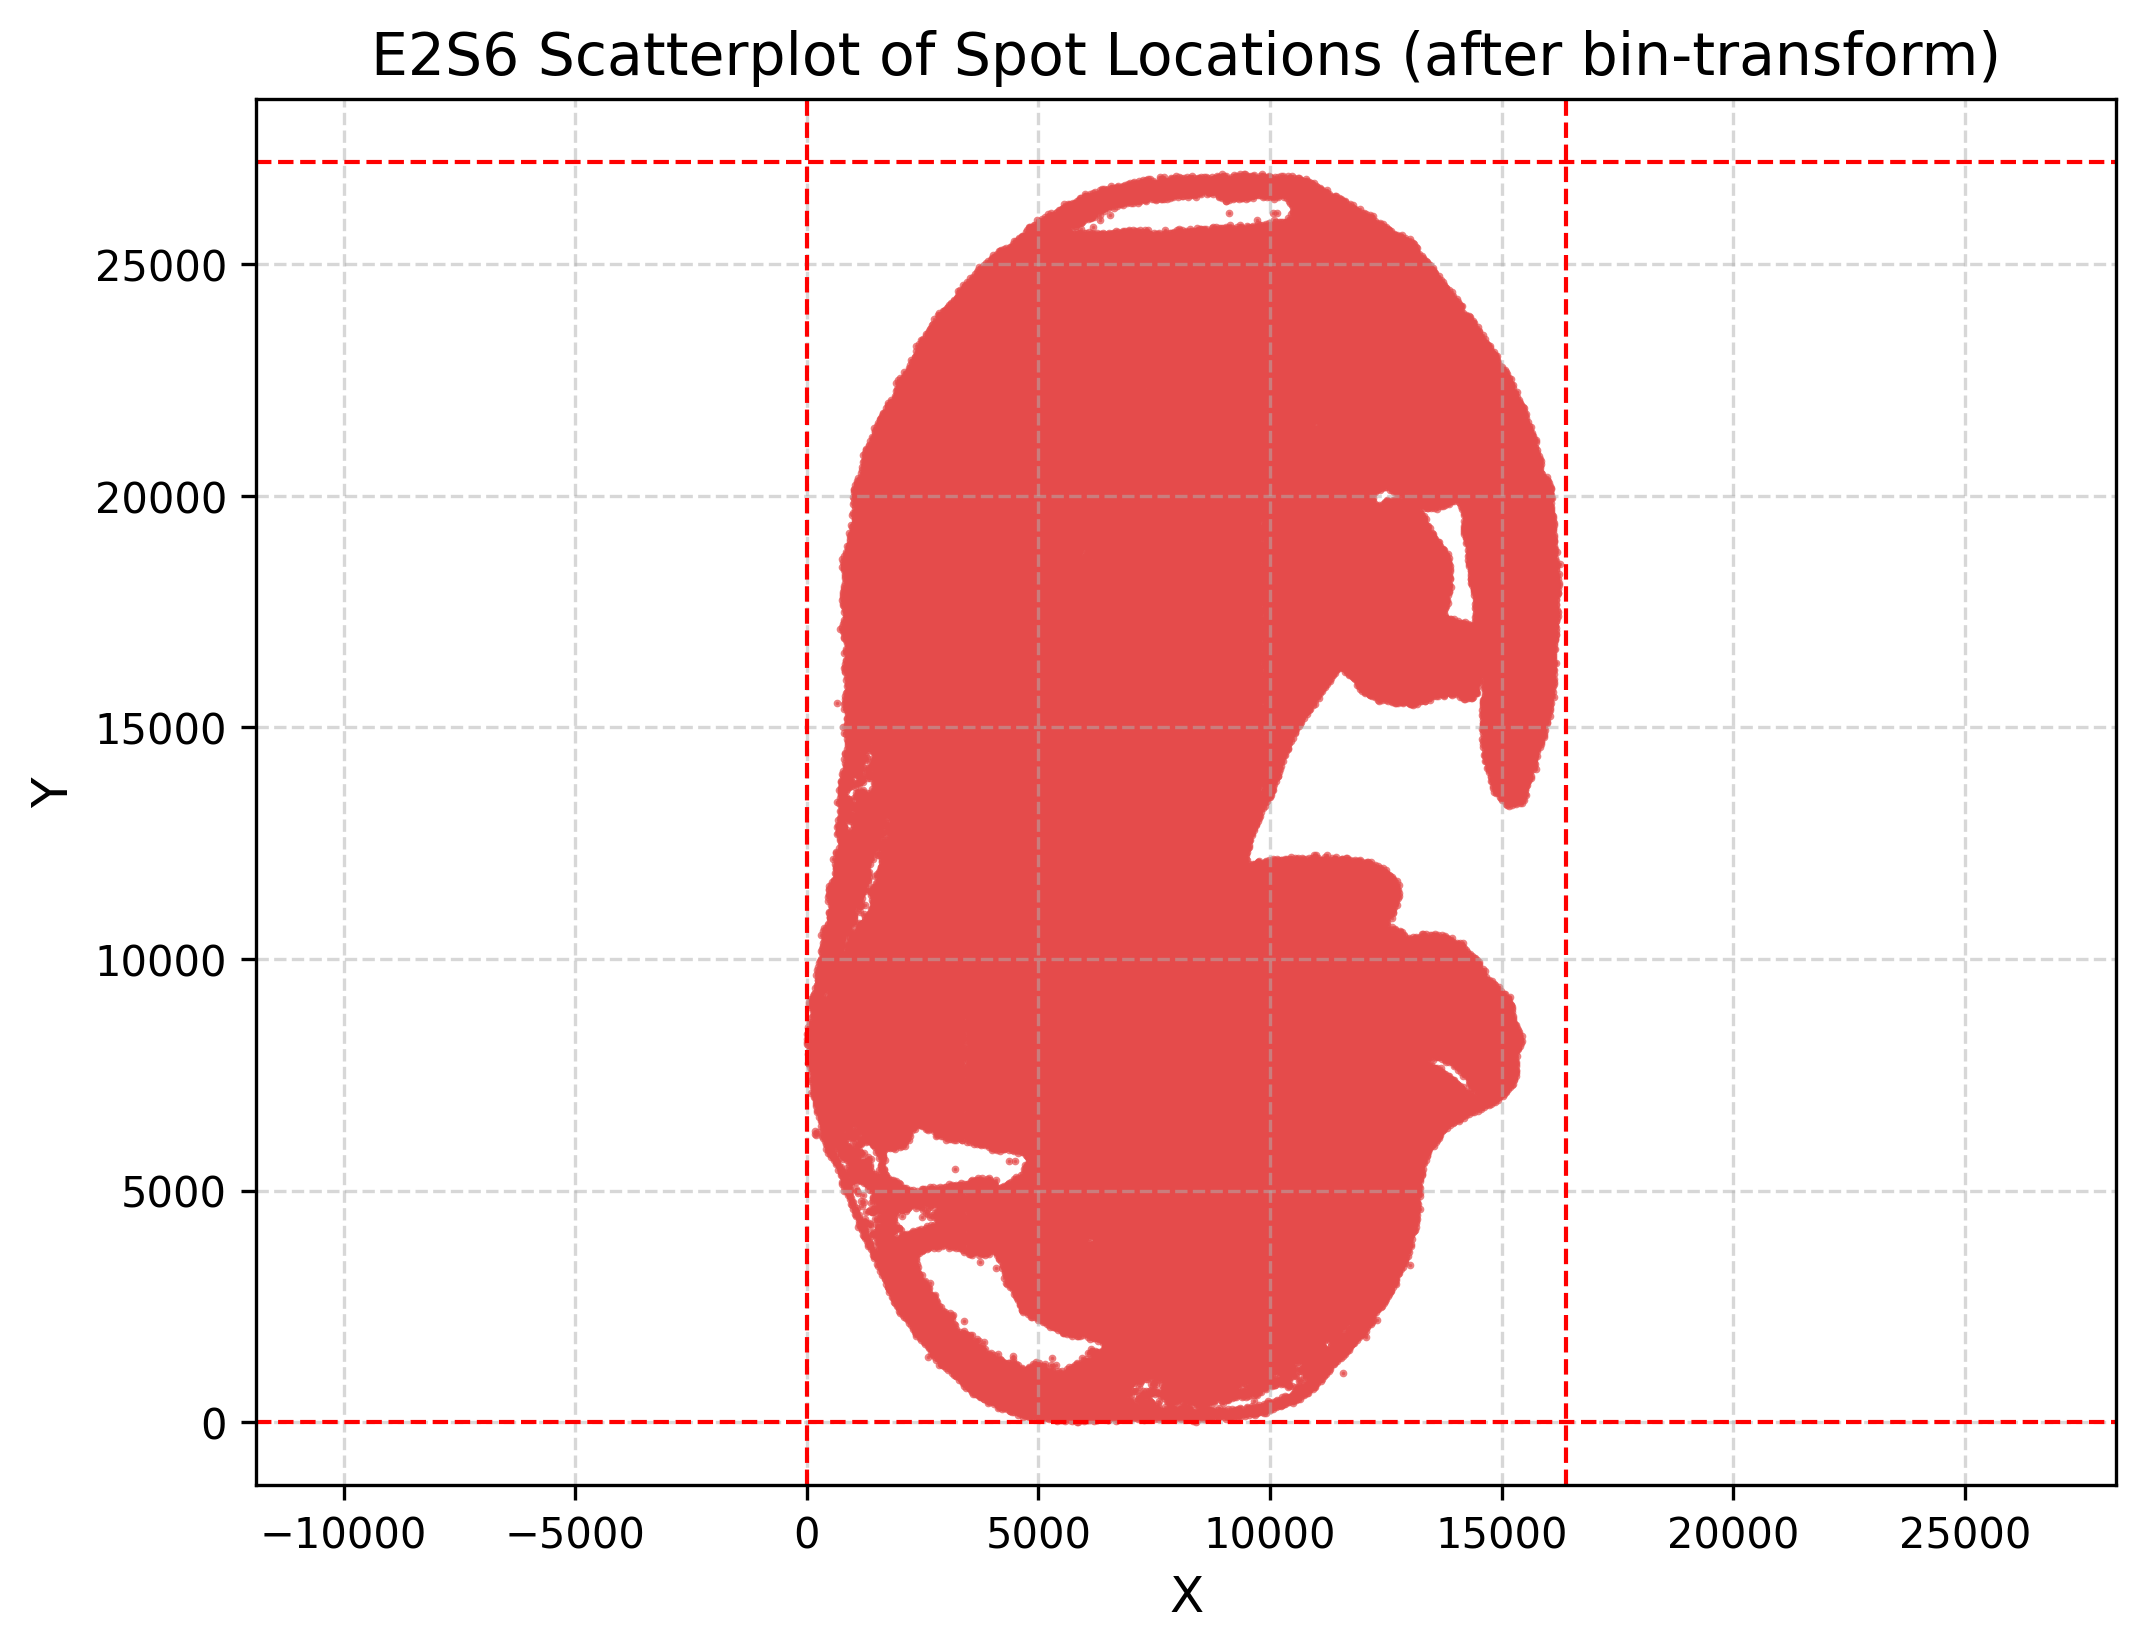

In [47]:
# Plot
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(e2s6_cm.obs['x_pxl'], e2s6_cm.obs['y_pxl'], c='#e54b4b', s=0.7, alpha=0.7)

# Add horizontal and vertical lines
plt.axhline(y=e2s6_img_width, color='red', linestyle='--', linewidth=1)
plt.axvline(x=e2s6_img_height, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

# Keep the same ratio for x and y
plt.axis('equal')

# Labels and Title
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('E2S6 Scatterplot of Spot Locations (after bin-transform)', fontsize=14)

# Show Plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

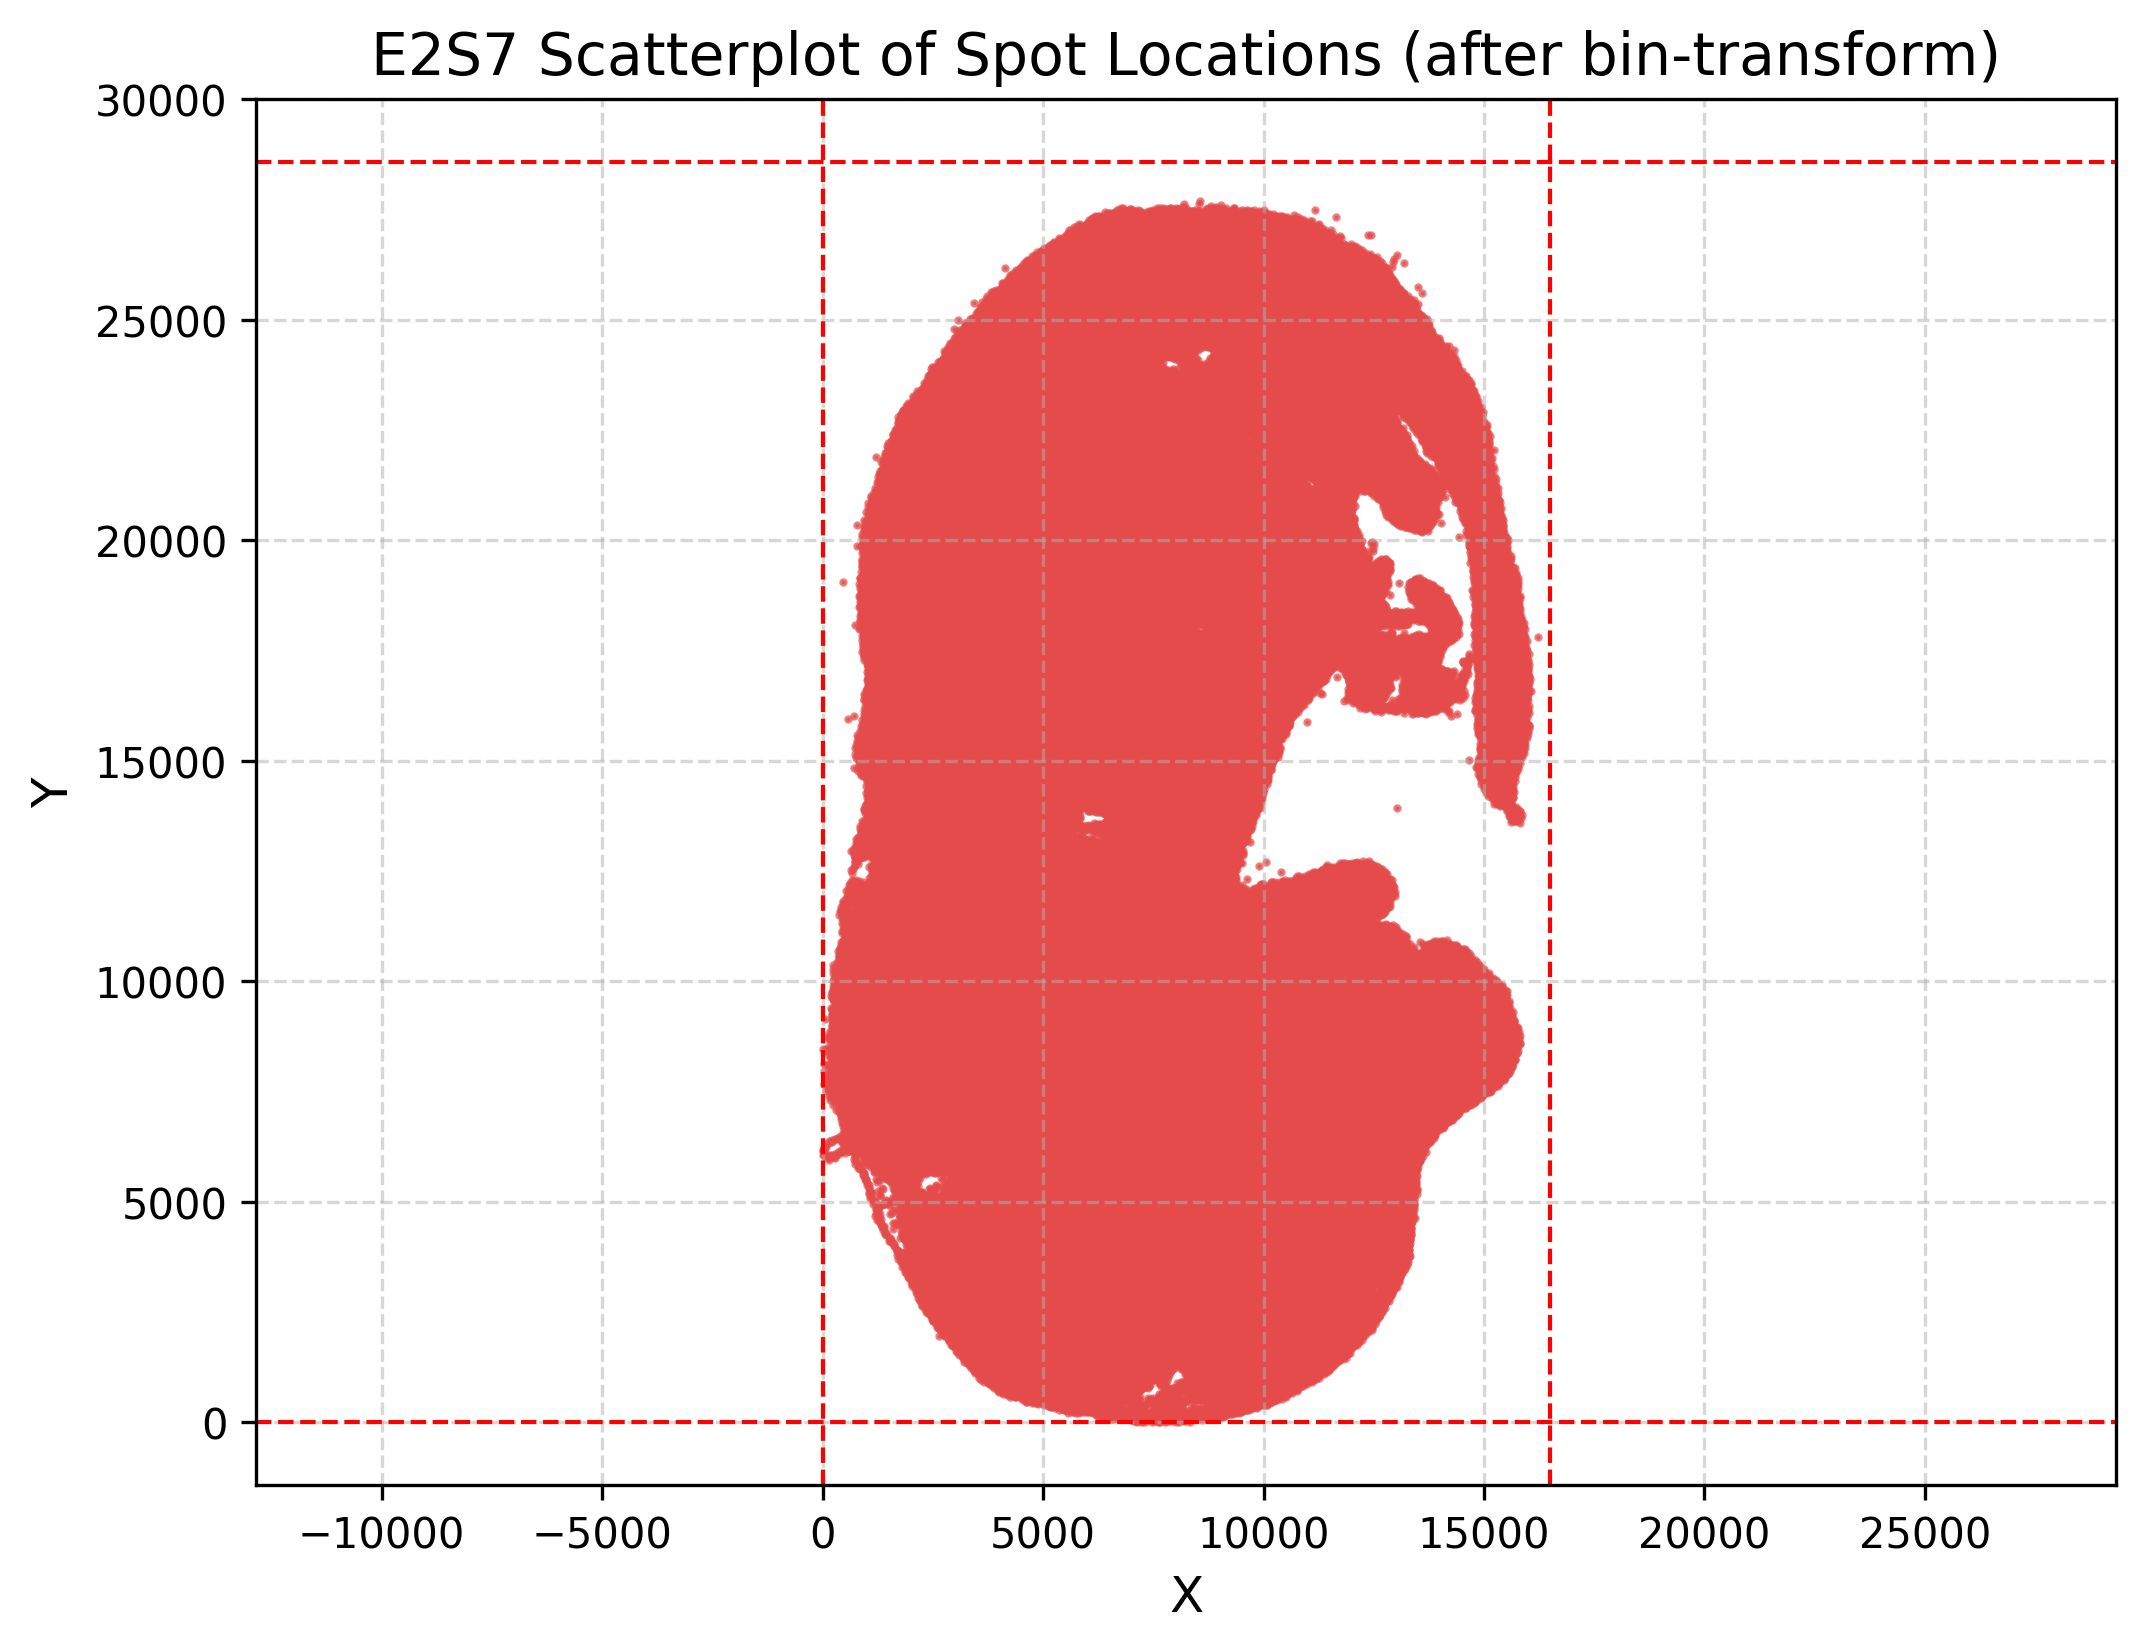

In [48]:
# Plot
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(e2s7_cm.obs['x_pxl'], e2s7_cm.obs['y_pxl'], c='#e54b4b', s=1, alpha=0.7)

# Add horizontal and vertical lines
plt.axhline(y=e2s7_img_width, color='red', linestyle='--', linewidth=1)
plt.axvline(x=e2s7_img_height, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

# Keep the same ratio for x and y
plt.axis('equal')

# Labels and Title
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('E2S7 Scatterplot of Spot Locations (after bin-transform)', fontsize=14)

# Show Plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

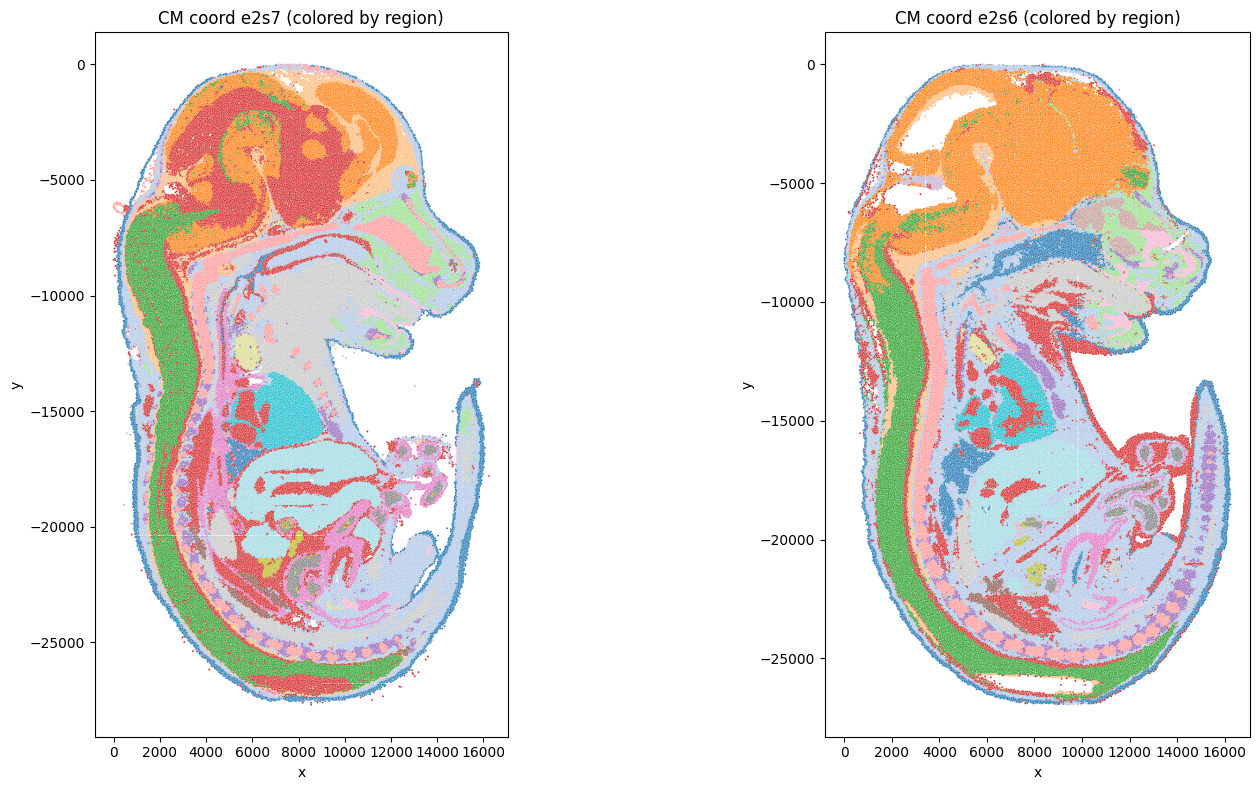

In [49]:
# Get unique annotations from both datasets
unique_annotations = pd.concat([e2s6_cm.obs['annotation'], e2s7_cm.obs['annotation']]).unique()

# Create a consistent color palette for all unique annotations
palette = dict(zip(unique_annotations, sns.color_palette("tab20", len(unique_annotations))))

# Set up the figure and subplots for side-by-side scatterplots with equal aspect ratio
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot tiles1 with the consistent color palette
sns.scatterplot(ax=axes[0], x=e2s7_cm.obs['x_pxl'], y=-e2s7_cm.obs['y_pxl'], hue='annotation', data=e2s7_cm.obs, s=2, palette=palette, legend=False)
axes[0].set_title('CM coord e2s7 (colored by region)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal', 'box')

# Plot tiles2 with the same color palette
sns.scatterplot(ax=axes[1], x=e2s6_cm.obs['x_pxl'], y=-e2s6_cm.obs['y_pxl'], hue='annotation', data=e2s6_cm.obs, s=2, palette=palette, legend=False)
axes[1].set_title('CM coord e2s6 (colored by region)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal', 'box')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [50]:
# match gene sets
e2s6_cm = e2s6_cm[:,e2s6_cm.var.index.isin(e2s7_cm.var.index)]
e2s7_cm = e2s7_cm[:,e2s7_cm.var.index.isin(e2s6_cm.var.index)]

# sort order of one of the two ad
new_var_order = e2s6_cm.var_names.intersection(e2s7_cm.var_names)
indices = [e2s7_cm.var_names.get_loc(gene) for gene in new_var_order]
adata1_sorted_X = e2s7_cm.X[:, indices]
adata1_sorted_var = e2s7_cm.var.loc[new_var_order]
# re build adata
e2s7_cm = ad.AnnData(X=adata1_sorted_X, var=adata1_sorted_var, obs=e2s7_cm.obs)

e2s6_cm.obs.index = 's1-'+e2s6_cm.obs.index
e2s7_cm.obs.index = 's2-'+e2s7_cm.obs.index

e2s6_cm.obs['section'] = 'e2s6'
e2s7_cm.obs['section'] = 'e2s7'

e2s6_cm.obs['x'] = e2s6_cm.obs['x_pxl']
e2s6_cm.obs['y'] = e2s6_cm.obs['y_pxl']

e2s7_cm.obs['x'] = e2s7_cm.obs['x_pxl']
e2s7_cm.obs['y'] = e2s7_cm.obs['y_pxl']

In [51]:
# Save
e2s6_cm.write_h5ad('/exports/humgen/bmanzato/benchmark/MOSTA_data/preprocessed_mosta_e2s6.h5ad')
e2s7_cm.write_h5ad('/exports/humgen/bmanzato/benchmark/MOSTA_data/preprocessed_mosta_e2s7.h5ad')